# Attention Heat Maps for QuarkGluon and TopLandscape Models

This notebook reproduces attention heat maps for two Particle Transformer models:
- QuarkGluon tagging model
- TopLandscape tagging model

Based on the implementation from AttentionGraphs.ipynb

In [1]:
# Import required libraries
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import torch
import copy
import torch.nn as nn
import math
from weaver.utils.logger import _logger
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import mplhep as hep

hep.style.use(hep.style.ROOT)

In [2]:
# Model paths from QGandTLAttention.py
qgtrained_modelpath = '/home/tim_legge/save_qg_model/on-qg_final_best_epoch_state.pt'
tltrained_modelpath = '/home/tim_legge/save_tl_model/on-tl_final_best_epoch_state.pt'

# Check if model files exist
qg_exists = os.path.exists(qgtrained_modelpath)
tl_exists = os.path.exists(tltrained_modelpath)

print(f"QuarkGluon model exists: {qg_exists}")
print(f"TopLandscape model exists: {tl_exists}")

if not qg_exists:
    print(f"QuarkGluon model not found at: {qgtrained_modelpath}")
if not tl_exists:
    print(f"TopLandscape model not found at: {tltrained_modelpath}")

QuarkGluon model exists: True
TopLandscape model exists: True


In [3]:
# Dataset-specific data loading will be handled by the feature building functions
# build_features_and_labels_qg() and build_features_and_labels_tl() in the cell above
# These functions are tailored to the specific feature sets and configurations
# used by the QuarkGluon and TopLandscape models respectively.

print("Dataset-specific feature builders are defined in the previous cell:")
print("- build_features_and_labels_qg() for QuarkGluon dataset")
print("- build_features_and_labels_tl() for TopLandscape dataset")

Dataset-specific feature builders are defined in the previous cell:
- build_features_and_labels_qg() for QuarkGluon dataset
- build_features_and_labels_tl() for TopLandscape dataset


In [4]:
# Feature building function (adapted from AttentionGraphs.ipynb and config files)
def build_features_and_labels_qg(tree, transform_features=True):
    """Build features for QuarkGluon dataset based on qg_kinpid.yaml"""
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])

    # apply standardization based on qg_kinpid.yaml
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    # Feature list for QuarkGluon (kinematic + particle ID)
    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'],
        'pf_features': [
            'part_pt_log',
            'part_e_log', 
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    def _pad(a, maxlen=128, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    # Labels for QuarkGluon (binary classification)
    out['label'] = a['label'].to_numpy().astype('int')
    
    return out

def build_features_and_labels_tl(tree, transform_features=True):
    """Build features for TopLandscape dataset based on top_kin.yaml"""
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label'])

    # compute new features (same as QG)
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])

    # apply standardization based on top_kin.yaml (same as QG)
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0

    # Feature list for TopLandscape (same kinematic features as QG)
    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'],
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel', 
            'part_logerel',
            'part_deltaR',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    def _pad(a, maxlen=128, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    # Labels for TopLandscape (binary classification) 
    out['label'] = a['label'].to_numpy().astype('int')

    return out

In [5]:
@torch.jit.script
def delta_phi(a, b):
    return (a - b + math.pi) % (2 * math.pi) - math.pi


@torch.jit.script
def delta_r2(eta1, phi1, eta2, phi2):
    return (eta1 - eta2)**2 + delta_phi(phi1, phi2)**2


def to_pt2(x, eps=1e-8):
    pt2 = x[:, :2].square().sum(dim=1, keepdim=True)
    if eps is not None:
        pt2 = pt2.clamp(min=eps)
    return pt2


def to_m2(x, eps=1e-8):
    m2 = x[:, 3:4].square() - x[:, :3].square().sum(dim=1, keepdim=True)
    if eps is not None:
        m2 = m2.clamp(min=eps)
    return m2


def atan2(y, x):
    sx = torch.sign(x)
    sy = torch.sign(y)
    pi_part = (sy + sx * (sy ** 2 - 1)) * (sx - 1) * (-math.pi / 2)
    atan_part = torch.arctan(y / (x + (1 - sx ** 2))) * sx ** 2
    return atan_part + pi_part


def to_ptrapphim(x, return_mass=True, eps=1e-8, for_onnx=False):
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    px, py, pz, energy = x.split((1, 1, 1, 1), dim=1)
    pt = torch.sqrt(to_pt2(x, eps=eps))
    # rapidity = 0.5 * torch.log((energy + pz) / (energy - pz))
    rapidity = 0.5 * torch.log(1 + (2 * pz) / (energy - pz).clamp(min=1e-20))
    phi = (atan2 if for_onnx else torch.atan2)(py, px)
    if not return_mass:
        return torch.cat((pt, rapidity, phi), dim=1)
    else:
        m = torch.sqrt(to_m2(x, eps=eps))
        return torch.cat((pt, rapidity, phi, m), dim=1)


def boost(x, boostp4, eps=1e-8):
    # boost x to the rest frame of boostp4
    # x: (N, 4, ...), dim1 : (px, py, pz, E)
    p3 = -boostp4[:, :3] / boostp4[:, 3:].clamp(min=eps)
    b2 = p3.square().sum(dim=1, keepdim=True)
    gamma = (1 - b2).clamp(min=eps)**(-0.5)
    gamma2 = (gamma - 1) / b2
    gamma2.masked_fill_(b2 == 0, 0)
    bp = (x[:, :3] * p3).sum(dim=1, keepdim=True)
    v = x[:, :3] + gamma2 * bp * p3 + x[:, 3:] * gamma * p3
    return v


def p3_norm(p, eps=1e-8):
    return p[:, :3] / p[:, :3].norm(dim=1, keepdim=True).clamp(min=eps)


def pairwise_lv_fts(xi, xj, num_outputs=4, eps=1e-8, for_onnx=False):
    pti, rapi, phii = to_ptrapphim(xi, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)
    ptj, rapj, phij = to_ptrapphim(xj, False, eps=None, for_onnx=for_onnx).split((1, 1, 1), dim=1)

    delta = delta_r2(rapi, phii, rapj, phij).sqrt()
    lndelta = torch.log(delta.clamp(min=eps))
    if num_outputs == 1:
        return lndelta

    if num_outputs > 1:
        ptmin = ((pti <= ptj) * pti + (pti > ptj) * ptj) if for_onnx else torch.minimum(pti, ptj)
        lnkt = torch.log((ptmin * delta).clamp(min=eps))
        lnz = torch.log((ptmin / (pti + ptj).clamp(min=eps)).clamp(min=eps))
        outputs = [lnkt, lnz, lndelta]

    if num_outputs > 3:
        xij = xi + xj
        lnm2 = torch.log(to_m2(xij, eps=eps))
        outputs.append(lnm2)

    if num_outputs > 4:
        lnds2 = torch.log(torch.clamp(-to_m2(xi - xj, eps=None), min=eps))
        outputs.append(lnds2)

    # the following features are not symmetric for (i, j)
    if num_outputs > 5:
        xj_boost = boost(xj, xij)
        costheta = (p3_norm(xj_boost, eps=eps) * p3_norm(xij, eps=eps)).sum(dim=1, keepdim=True)
        outputs.append(costheta)

    if num_outputs > 6:
        deltarap = rapi - rapj
        deltaphi = delta_phi(phii, phij)
        outputs += [deltarap, deltaphi]

    assert (len(outputs) == num_outputs)
    return torch.cat(outputs, dim=1)


def build_sparse_tensor(uu, idx, seq_len):
    # inputs: uu (N, C, num_pairs), idx (N, 2, num_pairs)
    # return: (N, C, seq_len, seq_len)
    batch_size, num_fts, num_pairs = uu.size()
    idx = torch.min(idx, torch.ones_like(idx) * seq_len)
    i = torch.cat((
        torch.arange(0, batch_size, device=uu.device).repeat_interleave(num_fts * num_pairs).unsqueeze(0),
        torch.arange(0, num_fts, device=uu.device).repeat_interleave(num_pairs).repeat(batch_size).unsqueeze(0),
        idx[:, :1, :].expand_as(uu).flatten().unsqueeze(0),
        idx[:, 1:, :].expand_as(uu).flatten().unsqueeze(0),
    ), dim=0)
    return torch.sparse_coo_tensor(
        i, uu.flatten(),
        size=(batch_size, num_fts, seq_len + 1, seq_len + 1),
        device=uu.device).to_dense()[:, :, :seq_len, :seq_len]


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From https://github.com/rwightman/pytorch-image-models/blob/18ec173f95aa220af753358bf860b16b6691edb2/timm/layers/weight_init.py#L8
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


In [6]:
class Embed(nn.Module):
    def __init__(self, input_dim, dims, normalize_input=True, activation='gelu'):
        super().__init__()

        self.input_bn = nn.BatchNorm1d(input_dim) if normalize_input else None
        module_list = []
        for dim in dims:
            module_list.extend([
                nn.LayerNorm(input_dim),
                nn.Linear(input_dim, dim),
                nn.GELU() if activation == 'gelu' else nn.ReLU(),
            ])
            input_dim = dim
        self.embed = nn.Sequential(*module_list)

    def forward(self, x):
        if self.input_bn is not None:
            # x: (batch, embed_dim, seq_len)
            x = self.input_bn(x)
            x = x.permute(2, 0, 1).contiguous()
        # x: (seq_len, batch, embed_dim)
        return self.embed(x)


class PairEmbed(nn.Module):
    def __init__(
            self, pairwise_lv_dim, pairwise_input_dim, dims,
            remove_self_pair=False, use_pre_activation_pair=True, mode='sum',
            normalize_input=True, activation='gelu', eps=1e-8,
            for_onnx=False):
        super().__init__()

        self.pairwise_lv_dim = pairwise_lv_dim
        self.pairwise_input_dim = pairwise_input_dim
        self.is_symmetric = (pairwise_lv_dim <= 5) and (pairwise_input_dim == 0)
        self.remove_self_pair = remove_self_pair
        self.mode = mode
        self.for_onnx = for_onnx
        self.pairwise_lv_fts = partial(pairwise_lv_fts, num_outputs=pairwise_lv_dim, eps=eps, for_onnx=for_onnx)
        self.out_dim = dims[-1]

        if self.mode == 'concat':
            input_dim = pairwise_lv_dim + pairwise_input_dim
            module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
            for dim in dims:
                module_list.extend([
                    nn.Conv1d(input_dim, dim, 1),
                    nn.BatchNorm1d(dim),
                    nn.GELU() if activation == 'gelu' else nn.ReLU(),
                ])
                input_dim = dim
            if use_pre_activation_pair:
                module_list = module_list[:-1]
            self.embed = nn.Sequential(*module_list)
        elif self.mode == 'sum':
            if pairwise_lv_dim > 0:
                input_dim = pairwise_lv_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.embed = nn.Sequential(*module_list)

            if pairwise_input_dim > 0:
                input_dim = pairwise_input_dim
                module_list = [nn.BatchNorm1d(input_dim)] if normalize_input else []
                for dim in dims:
                    module_list.extend([
                        nn.Conv1d(input_dim, dim, 1),
                        nn.BatchNorm1d(dim),
                        nn.GELU() if activation == 'gelu' else nn.ReLU(),
                    ])
                    input_dim = dim
                if use_pre_activation_pair:
                    module_list = module_list[:-1]
                self.fts_embed = nn.Sequential(*module_list)
        else:
            raise RuntimeError('`mode` can only be `sum` or `concat`')

    def forward(self, x, uu=None):
        # x: (batch, v_dim, seq_len)
        # uu: (batch, v_dim, seq_len, seq_len)
        assert (x is not None or uu is not None)
        with torch.no_grad():
            if x is not None:
                batch_size, _, seq_len = x.size()
            else:
                batch_size, _, seq_len, _ = uu.size()
            if self.is_symmetric and not self.for_onnx:
                i, j = torch.tril_indices(seq_len, seq_len, offset=-1 if self.remove_self_pair else 0,
                                          device=(x if x is not None else uu).device)
                if x is not None:
                    x = x.unsqueeze(-1).repeat(1, 1, 1, seq_len)
                    xi = x[:, :, i, j]  # (batch, dim, seq_len*(seq_len+1)/2)
                    xj = x[:, :, j, i]
                    x = self.pairwise_lv_fts(xi, xj)
                if uu is not None:
                    # (batch, dim, seq_len*(seq_len+1)/2)
                    uu = uu[:, :, i, j]
            else:
                if x is not None:
                    x = self.pairwise_lv_fts(x.unsqueeze(-1), x.unsqueeze(-2))
                    if self.remove_self_pair:
                        i = torch.arange(0, seq_len, device=x.device)
                        x[:, :, i, i] = 0
                    x = x.view(-1, self.pairwise_lv_dim, seq_len * seq_len)
                if uu is not None:
                    uu = uu.view(-1, self.pairwise_input_dim, seq_len * seq_len)
            if self.mode == 'concat':
                if x is None:
                    pair_fts = uu
                elif uu is None:
                    pair_fts = x
                else:
                    pair_fts = torch.cat((x, uu), dim=1)

        if self.mode == 'concat':
            elements = self.embed(pair_fts)  # (batch, embed_dim, num_elements)
        elif self.mode == 'sum':
            if x is None:
                elements = self.fts_embed(uu)
            elif uu is None:
                elements = self.embed(x)
            else:
                elements = self.embed(x) + self.fts_embed(uu)

        if self.is_symmetric and not self.for_onnx:
            y = torch.zeros(batch_size, self.out_dim, seq_len, seq_len, dtype=elements.dtype, device=elements.device)
            y[:, :, i, j] = elements
            y[:, :, j, i] = elements
        else:
            y = elements.view(-1, self.out_dim, seq_len, seq_len)
        return y

In [7]:
class SequenceTrimmer(nn.Module):

    def __init__(self, enabled=False, target=(0.9, 1.02), **kwargs) -> None:
        super().__init__(**kwargs)
        self.enabled = enabled
        self.target = target
        self._counter = 0

    def forward(self, x, v=None, mask=None, uu=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # uu: (N, C', P, P)
        if mask is None:
            mask = torch.ones_like(x[:, :1])
        mask = mask.bool()

        if self.enabled:
            if self._counter < 5:
                self._counter += 1
            else:
                if self.training:
                    q = min(1, random.uniform(*self.target))
                    maxlen = torch.quantile(mask.type_as(x).sum(dim=-1), q).long()
                    rand = torch.rand_like(mask.type_as(x))
                    rand.masked_fill_(~mask, -1)
                    perm = rand.argsort(dim=-1, descending=True)  # (N, 1, P)
                    mask = torch.gather(mask, -1, perm)
                    x = torch.gather(x, -1, perm.expand_as(x))
                    if v is not None:
                        v = torch.gather(v, -1, perm.expand_as(v))
                    if uu is not None:
                        uu = torch.gather(uu, -2, perm.unsqueeze(-1).expand_as(uu))
                        uu = torch.gather(uu, -1, perm.unsqueeze(-2).expand_as(uu))
                else:
                    maxlen = mask.sum(dim=-1).max()
                maxlen = max(maxlen, 1)
                if maxlen < mask.size(-1):
                    mask = mask[:, :, :maxlen]
                    x = x[:, :, :maxlen]
                    if v is not None:
                        v = v[:, :, :maxlen]
                    if uu is not None:
                        uu = uu[:, :, :maxlen, :maxlen]

        return x, v, mask, uu



class Block(nn.Module):
    def __init__(self, embed_dim=128, num_heads=8, ffn_ratio=4,
                 dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                 add_bias_kv=False, activation='gelu',
                 scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.ffn_dim = embed_dim * ffn_ratio
        self.interaction = None
        self.pre_mask_attn_weights = None  # To store attention weights before mask is applied

        self.pre_attn_norm = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim,
            num_heads,
            dropout=attn_dropout,
            add_bias_kv=add_bias_kv,
        )
        self.post_attn_norm = nn.LayerNorm(embed_dim) if scale_attn else None
        self.dropout = nn.Dropout(dropout)

        self.pre_fc_norm = nn.LayerNorm(embed_dim)
        self.fc1 = nn.Linear(embed_dim, self.ffn_dim)
        self.act = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.act_dropout = nn.Dropout(activation_dropout)
        self.post_fc_norm = nn.LayerNorm(self.ffn_dim) if scale_fc else None
        self.fc2 = nn.Linear(self.ffn_dim, embed_dim)

        self.c_attn = nn.Parameter(torch.ones(num_heads), requires_grad=True) if scale_heads else None
        self.w_resid = nn.Parameter(torch.ones(embed_dim), requires_grad=True) if scale_resids else None
    def getAttention(self):
        return self.interaction
    def getPreMaskAttention(self):
        return self.pre_mask_attn_weights
    def forward(self, x, x_cls=None, padding_mask=None, attn_mask=None):
        """
        Args:
            x (Tensor): input to the layer of shape (seq_len, batch, embed_dim)
            x_cls (Tensor, optional): class token input to the layer of shape (1, batch, embed_dim)
            padding_mask (ByteTensor, optional): binary
                ByteTensor of shape (batch, seq_len) where padding
                elements are indicated by `1.

        Returns:
            encoded output of shape (seq_len, batch, embed_dim)
        """

        if x_cls is not None:
            with torch.no_grad():
                # prepend one element for x_cls: -> (batch, 1+seq_len)
                padding_mask = torch.cat((torch.zeros_like(padding_mask[:, :1]), padding_mask), dim=1)
            # class attention: https://arxiv.org/pdf/2103.17239.pdf
            residual = x_cls
            u = torch.cat((x_cls, x), dim=0)  # (seq_len+1, batch, embed_dim)
            u = self.pre_attn_norm(u)
            x = self.attn(x_cls, u, u, key_padding_mask=padding_mask)[0]  # (1, batch, embed_dim)
        else:
            residual = x


            x = self.pre_attn_norm(x)


            x= self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask, average_attn_weights=False)[0]  # (seq_len, batch, embed_dim)
            y= self.attn(x, x, x, key_padding_mask=padding_mask,
                          attn_mask=attn_mask, average_attn_weights=False)[1]
            self.interaction = y


        if self.c_attn is not None:
            tgt_len = x.size(0)
            x = x.view(tgt_len, -1, self.num_heads, self.head_dim)
            x = torch.einsum('tbhd,h->tbdh', x, self.c_attn)
            x = x.reshape(tgt_len, -1, self.embed_dim)
        if self.post_attn_norm is not None:
            x = self.post_attn_norm(x)
        x = self.dropout(x)
        x += residual

        residual = x
        x = self.pre_fc_norm(x)
        x = self.act(self.fc1(x))
        x = self.act_dropout(x)
        if self.post_fc_norm is not None:
            x = self.post_fc_norm(x)
        x = self.fc2(x)
        x = self.dropout(x)
        if self.w_resid is not None:
            residual = torch.mul(self.w_resid, residual)
        x += residual

        return x

class ParticleTransformer(nn.Module):

    def __init__(self,
                 input_dim,
                 num_classes=10,
                 # network configurations
                 pair_input_dim=4,
                 pair_extra_dim=0,
                 remove_self_pair=False,
                 use_pre_activation_pair=True,
                 embed_dims=[64, 64, 64],
                 pair_embed_dims=[32, 32, 32],
                 num_heads=1,
                 num_layers=1,
                 num_cls_layers=1,
                 block_params=None,
                 cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
                 fc_params=[],
                 activation='gelu',
                 # misc
                 trim=True,
                 for_inference=False,
                 use_amp=False,
                 **kwargs) -> None:
        super().__init__(**kwargs)

        self.trimmer = SequenceTrimmer(enabled=trim and not for_inference)
        self.attention_matrix = []
        self.for_inference = for_inference
        self.use_amp = use_amp
        embed_dim = embed_dims[-1] if len(embed_dims) > 0 else input_dim
        default_cfg = dict(embed_dim=embed_dim, num_heads=num_heads, ffn_ratio=4,
                           dropout=0.1, attn_dropout=0.1, activation_dropout=0.1,
                           add_bias_kv=False, activation=activation,
                           scale_fc=True, scale_attn=True, scale_heads=True, scale_resids=True)
        self.pairMatrixes = []

        cfg_block = copy.deepcopy(default_cfg)
        if block_params is not None:
            cfg_block.update(block_params)
        _logger.info('cfg_block: %s' % str(cfg_block))

        cfg_cls_block = copy.deepcopy(default_cfg)
        if cls_block_params is not None:
            cfg_cls_block.update(cls_block_params)
        _logger.info('cfg_cls_block: %s' % str(cfg_cls_block))

        self.pair_extra_dim = pair_extra_dim
        self.embed = Embed(input_dim, embed_dims, activation=activation) if len(embed_dims) > 0 else nn.Identity()
        self.pair_embed = PairEmbed(
            pair_input_dim, pair_extra_dim, pair_embed_dims + [cfg_block['num_heads']],
            remove_self_pair=remove_self_pair, use_pre_activation_pair=use_pre_activation_pair,
            for_onnx=for_inference) if pair_embed_dims is not None and pair_input_dim + pair_extra_dim > 0 else None
        self.blocks = nn.ModuleList([Block(**cfg_block) for _ in range(num_layers)])
        self.cls_blocks = nn.ModuleList([Block(**cfg_cls_block) for _ in range(num_cls_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.interactionMatrix = None

        if fc_params is not None:
            fcs = []
            in_dim = embed_dim
            for out_dim, drop_rate in fc_params:
                fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
                in_dim = out_dim
            fcs.append(nn.Linear(in_dim, num_classes))
            self.fc = nn.Sequential(*fcs)
        else:
            self.fc = None

        # init
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)
        trunc_normal_(self.cls_token, std=.02)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token', }

    def getAttention(self):
        return self.attention_matrix

    def getInteraction(self):
        return self.interactionMatrix

    def getPairs(self):
        return self.pairMatrixes


    def forward(self, x, v=None, mask=None, uu=None, uu_idx=None):
        # x: (N, C, P)
        # v: (N, 4, P) [px,py,pz,energy]
        # mask: (N, 1, P) -- real particle = 1, padded = 0
        # for pytorch: uu (N, C', num_pairs), uu_idx (N, 2, num_pairs)
        # for onnx: uu (N, C', P, P), uu_idx=None

        with torch.no_grad():
            if not self.for_inference:
                if uu_idx is not None:
                    uu = build_sparse_tensor(uu, uu_idx, x.size(-1))
            x, v, mask, uu = self.trimmer(x, v, mask, uu)
            padding_mask = ~mask.squeeze(1)  # (N, P)

        with torch.cuda.amp.autocast(enabled=self.use_amp):
            # input embedding
            x = self.embed(x).masked_fill(~mask.permute(2, 0, 1), 0)  # (P, N, C)
            attn_mask = None
            if (v is not None or uu is not None) and self.pair_embed is not None:
                attn_mask = self.pair_embed(v, uu).view(-1, v.size(-1), v.size(-1))  # (N*num_heads, P, P)

            # transform
            #num = 0
            for block in self.blocks:

                x = block(x, x_cls=None, padding_mask=padding_mask, attn_mask=attn_mask)
                self.interactionMatrix = attn_mask
                #if num == 0 :
                self.attention_matrix.append(block.interaction)
                #num = num + 1

            # extract class token
            cls_tokens = self.cls_token.expand(1, x.size(1), -1)  # (1, N, C)
            for block in self.cls_blocks:
                cls_tokens = block(x, x_cls=cls_tokens, padding_mask=padding_mask)

            x_cls = self.norm(cls_tokens).squeeze(0)

            # fc
            if self.fc is None:
                return x_cls
            output = self.fc(x_cls)
            if self.for_inference:
                output = torch.softmax(output, dim=1)


            return output

class ParticleTransformerWrapper(torch.nn.Module):
    
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = ParticleTransformer(**kwargs)
        self.attention_matrix = None
        self.interactionMatrix = None
        self.pre_mask_attention_matrices = []

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        #self.pre_mask_attention_matrices = self.get_pre_mask_attention_matrices()
        return output

    def get_attention_matrix(self):
        return self.attention_matrix

    def get_interactionMatrix(self):
        return self.interactionMatrix

In [8]:
# Model configuration function
def get_model(model_type='qg', **kwargs):
    """Get model configuration for QuarkGluon or TopLandscape"""
    
    if model_type == 'qg':
        # QuarkGluon model configuration (13 kinpid features)
        cfg = dict(
            input_dim=13,  # pt_log, e_log, logptrel, logerel, deltaR, charge, isChargedHadron, isNeutralHadron, isPhoton, isElectron, isMuon, deta, dphi
            num_classes=2,  # Quark vs Gluon
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    elif model_type == 'tl':
        # TopLandscape model configuration (7 kinematic features)
        cfg = dict(
            input_dim=7,  # part_pt_log, part_e_log, part_logptrel, part_logerel, part_deltaR, part_deta, part_dphi
            num_classes=2,  # Top vs QCD
            pair_input_dim=4,
            use_pre_activation_pair=False,
            embed_dims=[128, 512, 128],
            pair_embed_dims=[64, 64, 64],
            num_heads=8,
            num_layers=8,
            num_cls_layers=2,
            block_params=None,
            cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
            fc_params=[],
            activation='gelu',
            trim=True,
            for_inference=False,
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}. Use 'qg' or 'tl'.")
    
    cfg.update(**kwargs)
    model = ParticleTransformerWrapper(**cfg)
    
    # Model info for compatibility
    model_info = {
        'input_names': ['pf_points', 'pf_features', 'pf_vectors', 'pf_mask'],
        'input_shapes': {
            'pf_points': (1, 2, 128),
            'pf_features': (1, cfg['input_dim'], 128),
            'pf_vectors': (1, 4, 128),
            'pf_mask': (1, 1, 128)
        },
        'output_names': ['softmax'],
    }
    
    return [model], model_info

In [9]:
# Attention visualization function
def plot_attention_heatmap(attention_matrix, jet_idx, layer_idx, head_idx, 
                          num_particles, title="Attention Heat Map", 
                          save_path=None, cmap='viridis'):
    """
    Plot attention heat map for a specific jet, layer, and head
    
    Args:
        attention_matrix: Attention matrix from model
        jet_idx: Index of the jet to visualize
        layer_idx: Index of the transformer layer
        head_idx: Index of the attention head
        num_particles: Number of valid particles (non-padded)
        title: Title for the plot
        save_path: Path to save the figure
        cmap: Colormap for the heatmap
    """
    
    plt.figure(figsize=(8, 6))
    
    # Extract the attention matrix for the specific jet, layer, and head
    if isinstance(attention_matrix, list) and len(attention_matrix) > layer_idx:
        if len(attention_matrix[layer_idx]) > jet_idx:
            attn = attention_matrix[layer_idx][head_idx, :num_particles, :num_particles]
        else:
            print(f"Jet {jet_idx} not found in attention matrices")
            return
    else:
        print(f"Layer {layer_idx} not found in attention matrices")
        return
    
    # Create the heatmap
    plt.imshow(attn, origin='lower', cmap=cmap, interpolation='nearest')
    
    # Add colorbar
    plt.colorbar(label='Attention Weight')
    
    # Set labels and title
    plt.xlabel('Particle Index')
    plt.ylabel('Particle Index')
    plt.title(f'{title}\nLayer {layer_idx+1}, Head {head_idx+1}, Jet {jet_idx}')
    
    # Set ticks
    plt.xticks(np.arange(0, num_particles, step=max(1, num_particles//10)))
    plt.yticks(np.arange(0, num_particles, step=max(1, num_particles//10)))
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Saved heatmap to {save_path}")
    
    plt.show()

In [10]:
# Function to load model and generate attention maps
def load_model_and_generate_attention(model_path, model_type, data_sample):
    """
    Load a trained model and generate attention maps
    
    Args:
        model_path: Path to the trained model
        model_type: 'qg' for QuarkGluon or 'tl' for TopLandscape
        data_sample: Sample data for inference
    
    Returns:
        attention_matrices: List of attention matrices per layer, or None if failed
    """
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}. "
                              f"Please ensure the model has been trained and saved at this location.")
    
    try:
        print(f"Loading {model_type.upper()} model from {model_path}")
        
        # Get model configuration
        model, model_info = get_model(model_type)
        
        # Load trained weights
        print("Loading model state dict...")
        state_dict = torch.load(model_path, map_location=torch.device('cpu'))
        
        # Handle different state dict formats
        if 'model' in state_dict:
            model_state = state_dict['model']
        elif 'state_dict' in state_dict:
            model_state = state_dict['state_dict']
        else:
            model_state = state_dict
            
        model[0].load_state_dict(model_state, strict=False)
        model[0].eval()
        
        print("Model loaded successfully, running inference...")
        
        # Run inference to get attention matrices
        with torch.no_grad():
            # Convert data to tensors
            pf_points = torch.from_numpy(data_sample['pf_points']).float()
            pf_features = torch.from_numpy(data_sample['pf_features']).float()
            pf_vectors = torch.from_numpy(data_sample['pf_vectors']).float()
            pf_mask = torch.from_numpy(data_sample['pf_mask']).float()
            
            print(f"Input shapes - points: {pf_points.shape}, features: {pf_features.shape}, "
                  f"vectors: {pf_vectors.shape}, mask: {pf_mask.shape}")
            
            # Run forward pass
            y_pred = model[0](pf_points, pf_features, pf_vectors, pf_mask)
            print(f"Forward pass completed, output shape: {y_pred.shape}")
            
            # Extract attention matrices
            attention_matrices = model[0].get_attention_matrix()
            
            if not attention_matrices:
                raise RuntimeError("No attention matrices were extracted during forward pass. "
                                 "This might indicate an issue with the attention hook registration.")
            
            print(f"Successfully extracted {len(attention_matrices)} attention matrices")
            return attention_matrices
            
    except ImportError as e:
        raise ImportError(f"Failed to import required modules: {e}. "
                        f"Please ensure weaver-core is installed: pip install 'weaver-core>=0.4'")
    except Exception as e:
        raise RuntimeError(f"Error during model loading or inference: {e}. "
                         f"Please check that the model file is compatible and not corrupted.")

In [11]:
def load_sample_data(dataset_type='qg', batch_size=10, num_particles=64):
    """
    Load sample data from actual dataset files or create realistic dummy data
    
    Args:
        dataset_type: 'qg' for QuarkGluon or 'tl' for TopLandscape
        batch_size: Number of jets to load
        num_particles: Maximum number of particles per jet
    """
    
    # Try to load actual data first
    try:
        if dataset_type == 'qg':
            # Try to load QuarkGluon data 
            data_path = "qg_test_file_0.root"
            if os.path.exists(data_path):
                print(f"Loading actual QuarkGluon data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - QG')
                    data = build_features_and_labels_qg(tree)

                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size], 
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                            
                        }
                    return data

        elif dataset_type == 'tl':
            # Try to load TopLandscape data
            data_path = "tl_test_file_0.root"
            if os.path.exists(data_path):
                print(f"Loading actual TopLandscape data from {data_path}")
                with uproot.open(data_path)['tree'] as tree:
                    print('This part is working - TL')
                    data = build_features_and_labels_tl(tree)

                    # Truncate to batch_size
                    if data['pf_points'].shape[0] > batch_size:
                        print(f"Truncating from {data['pf_points'].shape[0]} jets to {batch_size} jets")
                        data = {
                            'pf_points': data['pf_points'][:batch_size],
                            'pf_features': data['pf_features'][:batch_size],
                            'pf_vectors': data['pf_vectors'][:batch_size],
                            'pf_mask': data['pf_mask'][:batch_size],
                        
                        }
                    return data
                
    except Exception as e:
        print(f"Could not load actual data: {e}")
        raise e

# Create sample data for both models
print("Creating sample data for testing...")
qg_sample_data = load_sample_data('qg')
tl_sample_data = load_sample_data('tl')

print(f"QG sample data shapes:")
for k, v in qg_sample_data.items():
    print(f"  {k}: {v.shape}")
    
print(f"TL sample data shapes:")
for k, v in tl_sample_data.items():
    print(f"  {k}: {v.shape}")

print(f"\nFeature dimensions:")
print(f"  QuarkGluon (kinpid): {qg_sample_data['pf_features'].shape[1]} features")
print(f"  TopLandscape (kin): {tl_sample_data['pf_features'].shape[1]} features")

Creating sample data for testing...
Loading actual QuarkGluon data from qg_test_file_0.root
This part is working - QG
Truncating from 99999 jets to 10 jets
Loading actual TopLandscape data from tl_test_file_0.root
This part is working - TL
Truncating from 403999 jets to 10 jets
QG sample data shapes:
  pf_points: (10, 2, 128)
  pf_features: (10, 13, 128)
  pf_vectors: (10, 4, 128)
  pf_mask: (10, 1, 128)
TL sample data shapes:
  pf_points: (10, 2, 128)
  pf_features: (10, 7, 128)
  pf_vectors: (10, 4, 128)
  pf_mask: (10, 1, 128)

Feature dimensions:
  QuarkGluon (kinpid): 13 features
  TopLandscape (kin): 7 features


=== QuarkGluon Model Attention Analysis ===
Loading QG model from /home/tim_legge/save_qg_model/on-qg_final_best_epoch_state.pt
Loading model state dict...
Model loaded successfully, running inference...
Input shapes - points: torch.Size([10, 2, 128]), features: torch.Size([10, 13, 128]), vectors: torch.Size([10, 4, 128]), mask: torch.Size([10, 1, 128])
Forward pass completed, output shape: torch.Size([10, 2])
Successfully extracted 8 attention matrices
Successfully generated attention matrices for 8 layers
First layer attention shape: torch.Size([10, 8, 128, 128])
Attention tensor format: <class 'torch.Tensor'>

Plotting attention for jet 0 with 79 valid particles
Saved heatmap to qg_attention_L1_H1_J0.png


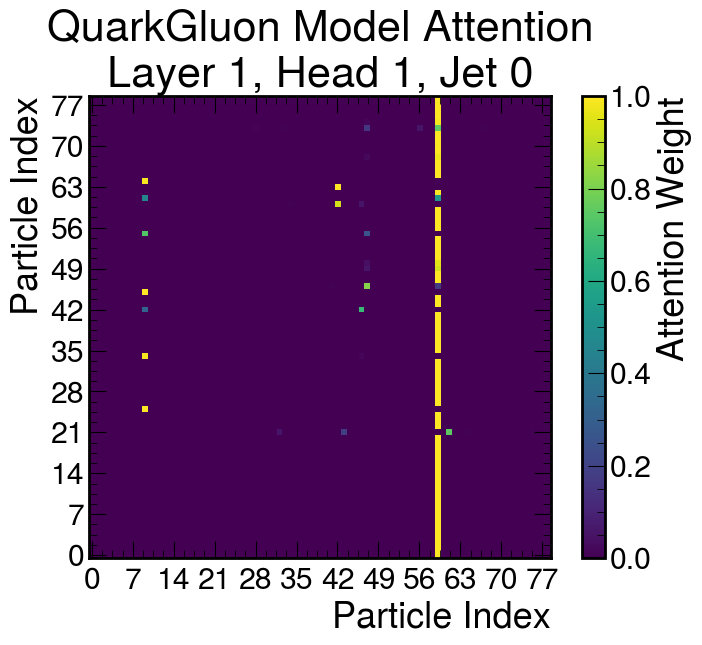

Saved heatmap to qg_attention_L1_H5_J0.png


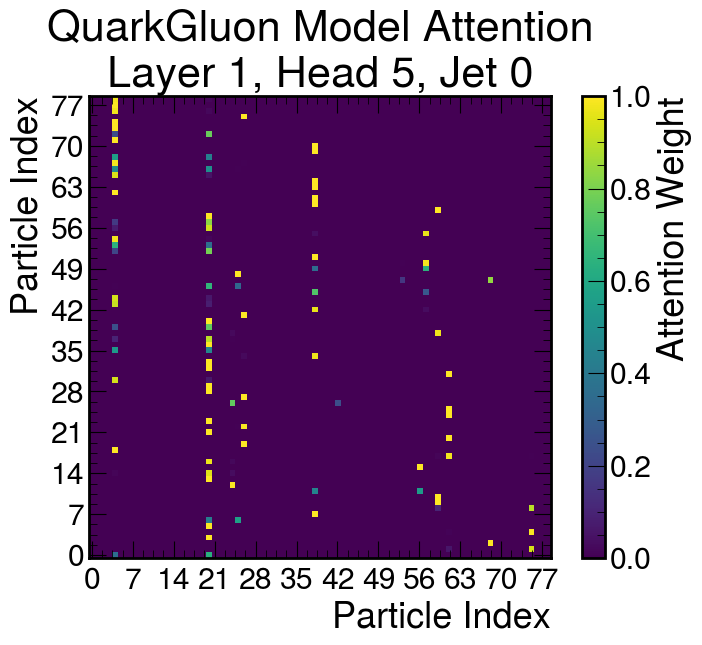

Saved heatmap to qg_attention_L5_H1_J0.png


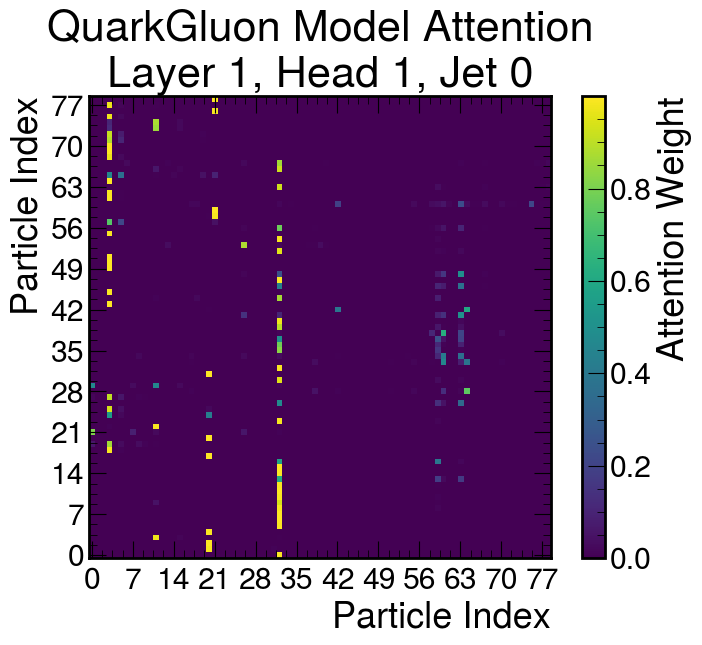

Saved heatmap to qg_attention_L5_H5_J0.png


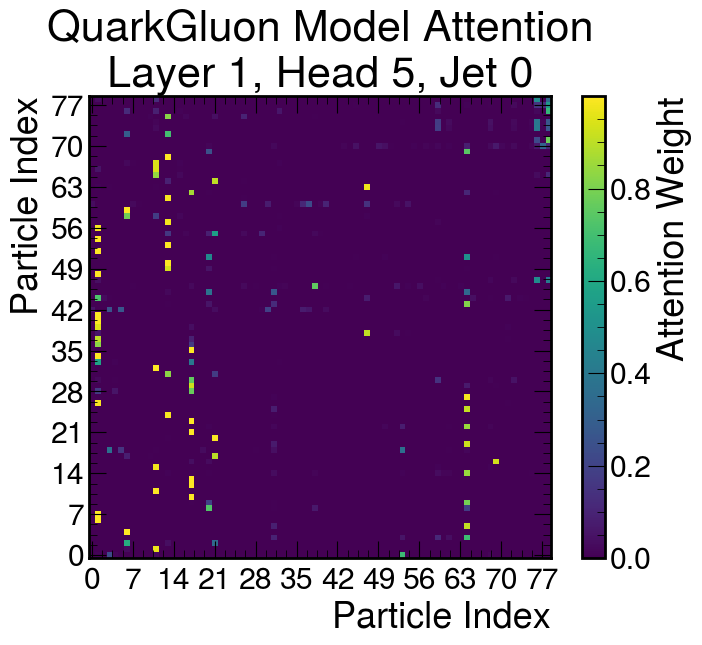

Saved heatmap to qg_attention_L8_H1_J0.png


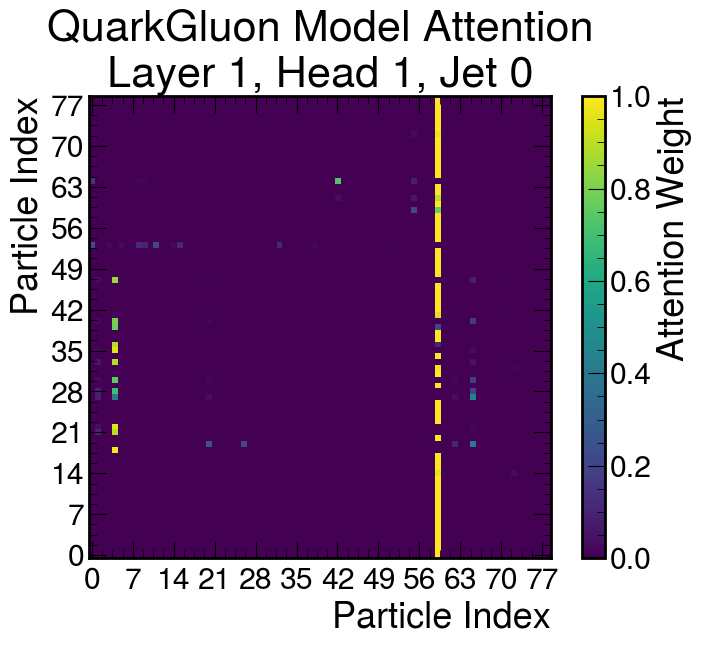

Saved heatmap to qg_attention_L8_H5_J0.png


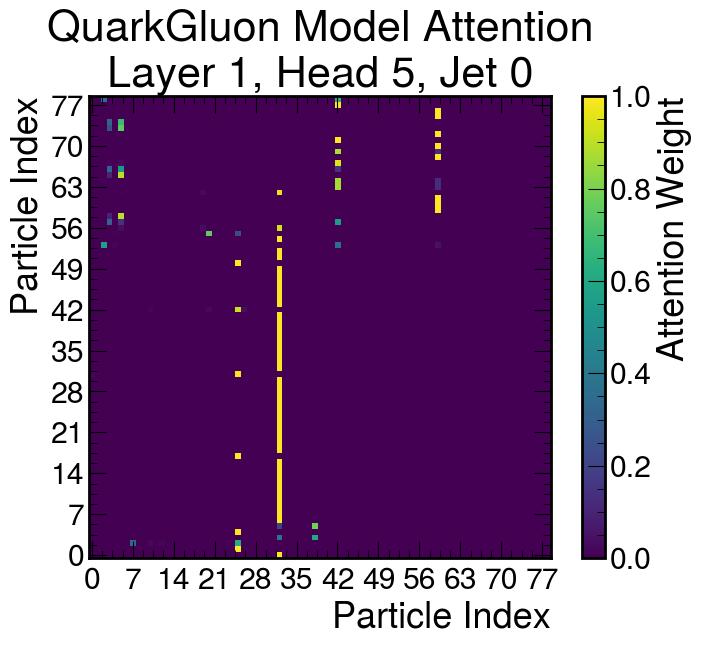

QuarkGluon attention analysis completed successfully


In [34]:
# Generate attention maps for QuarkGluon model
print("=== QuarkGluon Model Attention Analysis ===")

try:
    qg_attention = load_model_and_generate_attention(qgtrained_modelpath, 'qg', qg_sample_data)
    
    print(f"Successfully generated attention matrices for {len(qg_attention)} layers")
    
    # Analyze the structure of extracted attention
    if qg_attention:
        first_layer_attn = qg_attention[0]
        print(f"First layer attention shape: {first_layer_attn.shape}")
        print(f"Attention tensor format: {type(first_layer_attn)}")
        
        # Convert to numpy if needed
        if hasattr(first_layer_attn, 'numpy'):
            qg_attention = [attn.numpy() for attn in qg_attention]
        
        # Plot attention heatmaps for first few jets and layers
        jet_idx = 0
        #num_valid_particles = int(np.sum(qg_sample_data['pf_mask'][jet_idx, 0, :]))
        num_valid_particles = int(np.sum(qg_sample_data['pf_mask'][jet_idx, :]))

        print(f"\nPlotting attention for jet {jet_idx} with {num_valid_particles} valid particles")
        
        # Plot attention for different layers and heads
        for layer_idx in [0, len(qg_attention)//2, len(qg_attention)-1]:  # First, middle, and last layers
            if layer_idx < len(qg_attention):
                attn_matrix = qg_attention[layer_idx]
                
                # Handle different attention matrix formats
                if len(attn_matrix.shape) == 4:  # (batch, heads, seq, seq)
                    batch_attn = attn_matrix[jet_idx]  # (heads, seq, seq)
                elif len(attn_matrix.shape) == 3:  # (heads, seq, seq) for single batch
                    batch_attn = attn_matrix
                else:
                    print(f"Unexpected attention matrix shape: {attn_matrix.shape}")
                    continue
                
                num_heads = batch_attn.shape[0]
                for head_idx in [0, num_heads//2]:  # First and middle heads
                    if head_idx < num_heads:
                        plot_attention_heatmap(
                            [batch_attn],  # Wrap in list for compatibility
                            0,  # jet index (already selected)
                            0,  # layer index (already selected)
                            head_idx, 
                            num_valid_particles, 
                            title=f"QuarkGluon Model Attention",
                            save_path=f"qg_attention_L{layer_idx+1}_H{head_idx+1}_J{jet_idx}.png"
                        )
        
        print("QuarkGluon attention analysis completed successfully")
        
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please ensure the QuarkGluon model has been trained and saved.")
    qg_attention = None
    
except ImportError as e:
    print(f"ERROR: {e}")
    print("Please install required dependencies.")
    qg_attention = None
    
except Exception as e:
    print(f"ERROR during QuarkGluon model analysis: {e}")
    print("Failed to generate QuarkGluon attention matrices")
    qg_attention = None


=== TopLandscape Model Attention Analysis ===
Loading TL model from /home/tim_legge/save_tl_model/on-tl_final_best_epoch_state.pt
Loading model state dict...
Model loaded successfully, running inference...
Input shapes - points: torch.Size([10, 2, 128]), features: torch.Size([10, 7, 128]), vectors: torch.Size([10, 4, 128]), mask: torch.Size([10, 1, 128])
Forward pass completed, output shape: torch.Size([10, 2])
Successfully extracted 8 attention matrices
Successfully generated attention matrices for 8 layers
First layer attention shape: torch.Size([10, 8, 128, 128])
Attention tensor format: <class 'torch.Tensor'>

Plotting attention for jet 1 with 61 valid particles
Saved heatmap to tl_attention_L1_H1_J1.png


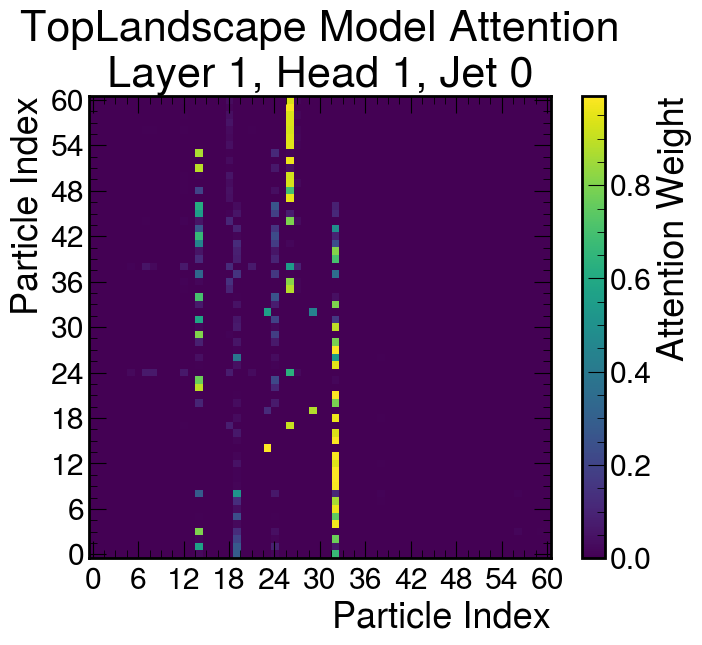

Saved heatmap to tl_attention_L1_H5_J1.png


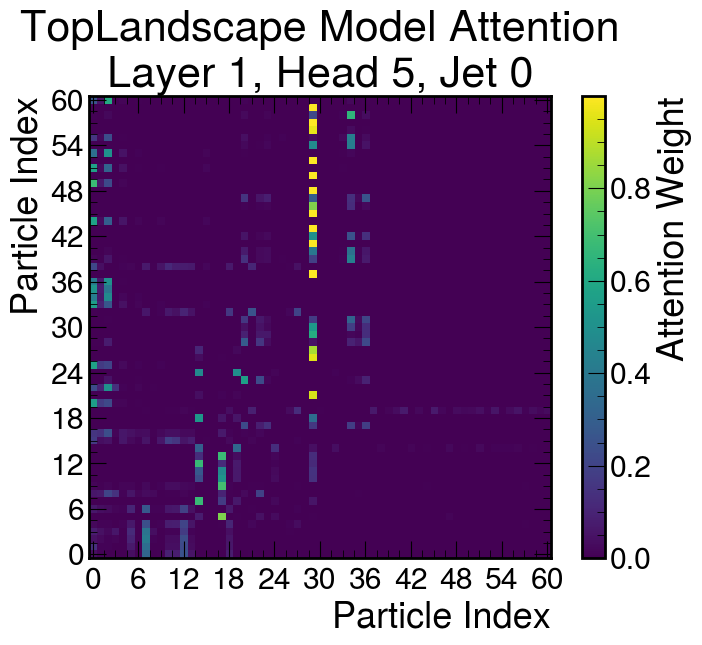

Saved heatmap to tl_attention_L5_H1_J1.png


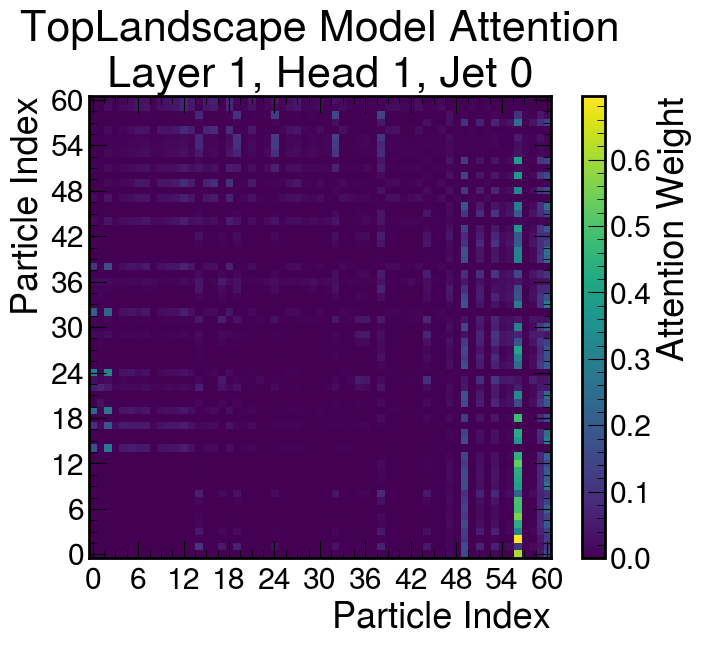

Saved heatmap to tl_attention_L5_H5_J1.png


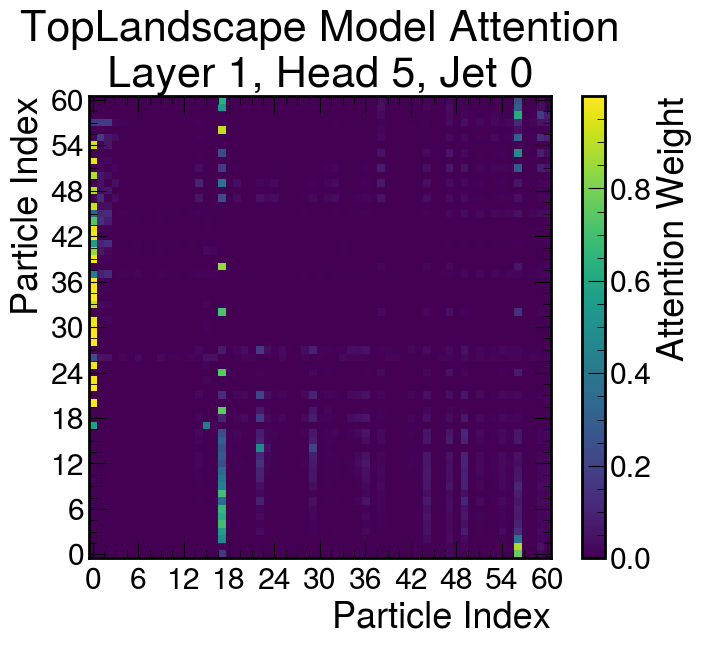

Saved heatmap to tl_attention_L8_H1_J1.png


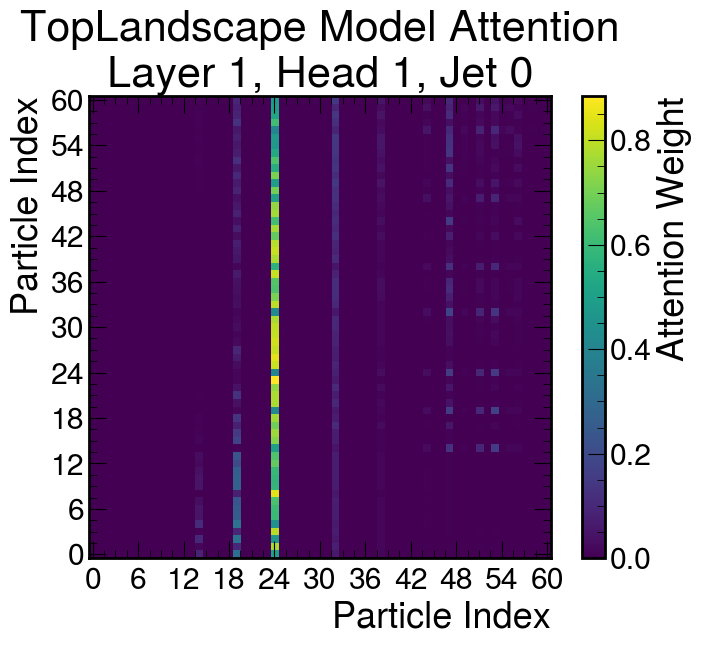

Saved heatmap to tl_attention_L8_H5_J1.png


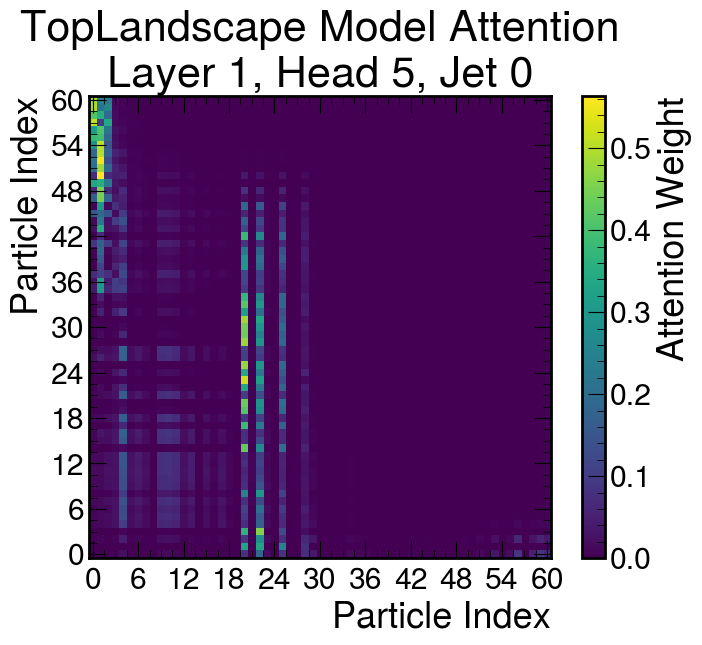

TopLandscape attention analysis completed successfully


In [13]:
# Generate attention maps for TopLandscape model
print("\n=== TopLandscape Model Attention Analysis ===")

try:
    tl_attention = load_model_and_generate_attention(tltrained_modelpath, 'tl', tl_sample_data)
    
    print(f"Successfully generated attention matrices for {len(tl_attention)} layers")
    
    # Analyze the structure of extracted attention
    if tl_attention:
        first_layer_attn = tl_attention[0]
        print(f"First layer attention shape: {first_layer_attn.shape}")
        print(f"Attention tensor format: {type(first_layer_attn)}")
        
        # Convert to numpy if needed
        if hasattr(first_layer_attn, 'numpy'):
            tl_attention = [attn.numpy() for attn in tl_attention]
        
        # Plot attention heatmaps for first few jets and layers
        jet_idx = 1
        num_valid_particles = int(np.sum(tl_sample_data['pf_mask'][jet_idx, :]))

        print(f"\nPlotting attention for jet {jet_idx} with {num_valid_particles} valid particles")
        
        # Plot attention for different layers and heads
        for layer_idx in [0, len(tl_attention)//2, len(tl_attention)-1]:  # First, middle, and last layers
            if layer_idx < len(tl_attention):
                attn_matrix = tl_attention[layer_idx]
                
                # Handle different attention matrix formats
                if len(attn_matrix.shape) == 4:  # (batch, heads, seq, seq)
                    batch_attn = attn_matrix[jet_idx]  # (heads, seq, seq)
                elif len(attn_matrix.shape) == 3:  # (heads, seq, seq) for single batch
                    batch_attn = attn_matrix
                else:
                    print(f"Unexpected attention matrix shape: {attn_matrix.shape}")
                    continue
                
                num_heads = batch_attn.shape[0]
                for head_idx in [0, num_heads//2]:  # First and middle heads
                    if head_idx < num_heads:
                        plot_attention_heatmap(
                            [batch_attn],  # Wrap in list for compatibility
                            0,  # jet index (already selected)
                            0,  # layer index (already selected)
                            head_idx, 
                            num_valid_particles, 
                            title=f"TopLandscape Model Attention",
                            save_path=f"tl_attention_L{layer_idx+1}_H{head_idx+1}_J{jet_idx}.png"
                        )
        
        print("TopLandscape attention analysis completed successfully")
        
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please ensure the TopLandscape model has been trained and saved.")
    tl_attention = None
    
except ImportError as e:
    print(f"ERROR: {e}")
    print("Please install required dependencies.")
    tl_attention = None
    
except Exception as e:
    print(f"ERROR during TopLandscape model analysis: {e}")
    print("Failed to generate TopLandscape attention matrices")
    tl_attention = None

In [ ]:
# Comparison function to analyze differences between models
def compare_attention_patterns(qg_attention, tl_attention, jet_idx=0, layer_idx=0, head_idx=0):
    """
    Compare attention patterns between QuarkGluon and TopLandscape models
    """
    
    if qg_attention is None or tl_attention is None:
        print("Cannot compare attention patterns - one or both models failed to load.")
        if qg_attention is None:
            print("  - QuarkGluon model attention matrices not available")
        if tl_attention is None:
            print("  - TopLandscape model attention matrices not available")
        return
    
    try:
        # Ensure we have enough layers
        max_layer = min(len(qg_attention), len(tl_attention)) - 1
        if layer_idx > max_layer:
            layer_idx = max_layer
            print(f"Adjusted layer_idx to {layer_idx} (maximum available)")
        
        # Extract attention matrices for the specified layer
        qg_layer_attn = qg_attention[layer_idx]
        tl_layer_attn = tl_attention[layer_idx]
        
        # Handle different tensor formats
        if len(qg_layer_attn.shape) == 4:  # (batch, heads, seq, seq)
            qg_attn = qg_layer_attn[jet_idx, head_idx]
        elif len(qg_layer_attn.shape) == 3:  # (heads, seq, seq)
            qg_attn = qg_layer_attn[head_idx]
        else:
            print(f"Unexpected QG attention shape: {qg_layer_attn.shape}")
            return
            
        if len(tl_layer_attn.shape) == 4:  # (batch, heads, seq, seq)
            tl_attn = tl_layer_attn[jet_idx, head_idx]
        elif len(tl_layer_attn.shape) == 3:  # (heads, seq, seq)
            tl_attn = tl_layer_attn[head_idx]
        else:
            print(f"Unexpected TL attention shape: {tl_layer_attn.shape}")
            return
        
        # Get the number of valid particles
        qg_valid = int(np.sum(qg_sample_data['pf_mask'][jet_idx, 0, :]))
        tl_valid = int(np.sum(tl_sample_data['pf_mask'][jet_idx, 0, :]))
        num_valid_particles = min(qg_valid, tl_valid)
        
        # Extract the relevant portions
        qg_attn = qg_attn[:num_valid_particles, :num_valid_particles]
        tl_attn = tl_attn[:num_valid_particles, :num_valid_particles]
        
        # Create comparison plot
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot QG attention
        im1 = axes[0].imshow(qg_attn, origin='lower', cmap='viridis')
        axes[0].set_title(f'QuarkGluon Model\nLayer {layer_idx+1}, Head {head_idx+1}')
        axes[0].set_xlabel('Particle Index')
        axes[0].set_ylabel('Particle Index')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot TL attention
        im2 = axes[1].imshow(tl_attn, origin='lower', cmap='viridis')
        axes[1].set_title(f'TopLandscape Model\nLayer {layer_idx+1}, Head {head_idx+1}')
        axes[1].set_xlabel('Particle Index')
        axes[1].set_ylabel('Particle Index')
        plt.colorbar(im2, ax=axes[1])
        
        # Plot difference
        diff = qg_attn - tl_attn
        max_diff = np.max(np.abs(diff))
        im3 = axes[2].imshow(diff, origin='lower', cmap='RdBu_r', 
                            vmin=-max_diff, vmax=max_diff)
        axes[2].set_title(f'Difference (QG - TL)\nLayer {layer_idx+1}, Head {head_idx+1}')
        axes[2].set_xlabel('Particle Index')
        axes[2].set_ylabel('Particle Index')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        plt.savefig(f'attention_comparison_L{layer_idx+1}_H{head_idx+1}_J{jet_idx}.png', 
                    bbox_inches='tight', dpi=300)
        plt.show()
        
        # Compute and print statistics
        correlation = np.corrcoef(qg_attn.flatten(), tl_attn.flatten())[0, 1]
        mse = np.mean((qg_attn - tl_attn)**2)
        
        print(f"Attention Pattern Comparison (Layer {layer_idx+1}, Head {head_idx+1}):")
        print(f"  Correlation: {correlation:.4f}")
        print(f"  Mean Squared Error: {mse:.6f}")
        print(f"  Max absolute difference: {max_diff:.6f}")
        print(f"  QG attention range: [{qg_attn.min():.6f}, {qg_attn.max():.6f}]")
        print(f"  TL attention range: [{tl_attn.min():.6f}, {tl_attn.max():.6f}]")
        
    except Exception as e:
        print(f"Error during attention comparison: {e}")

# Compare attention patterns if both models loaded successfully
print("\n=== Attention Pattern Comparison ===")
if 'qg_attention' in locals() and 'tl_attention' in locals():
    compare_attention_patterns(qg_attention, tl_attention, jet_idx=0, layer_idx=0, head_idx=0)
else:
    print("Skipping comparison - attention matrices not available for both models")
    if 'qg_attention' not in locals() or qg_attention is None:
        print("  - QuarkGluon attention matrices missing")
    if 'tl_attention' not in locals() or tl_attention is None:
        print("  - TopLandscape attention matrices missing")

In [ ]:
# Summary statistics and analysis
def analyze_attention_statistics(attention_matrices, model_name, sample_data):
    """
    Analyze statistical properties of attention matrices
    """
    print(f"\n=== {model_name} Attention Statistics ===")
    
    if attention_matrices is None:
        print(f"No attention matrices available for {model_name} model")
        print("Possible reasons:")
        print("  - Model file not found")
        print("  - Model loading failed")
        print("  - Attention extraction failed")
        return
    
    try:
        num_layers = len(attention_matrices)
        if num_layers == 0:
            print("No attention layers found")
            return
        
        # Analyze first layer to understand structure
        first_layer = attention_matrices[0]
        print(f"Model structure: {num_layers} layers")
        print(f"First layer attention shape: {first_layer.shape}")
        
        # Handle different attention matrix formats
        if len(first_layer.shape) == 4:  # (batch, heads, seq, seq)
            batch_size, num_heads, seq_len, _ = first_layer.shape
            print(f"Batch size: {batch_size}, Heads: {num_heads}, Sequence length: {seq_len}")
        elif len(first_layer.shape) == 3:  # (heads, seq, seq)  
            num_heads, seq_len, _ = first_layer.shape
            batch_size = 1
            print(f"Heads: {num_heads}, Sequence length: {seq_len}")
        else:
            print(f"Unexpected attention matrix shape: {first_layer.shape}")
            return
        
        # Compute statistics across all layers
        all_attention_values = []
        layer_entropies = []
        layer_sparsities = []
        
        for layer_idx in range(num_layers):
            layer_attn = attention_matrices[layer_idx]
            
            # Convert to numpy if needed
            if hasattr(layer_attn, 'numpy'):
                layer_attn = layer_attn.numpy()
            
            # Collect all attention values from this layer
            layer_values = layer_attn.flatten()
            all_attention_values.extend(layer_values)
            
            # Compute entropy (measure of attention distribution)
            # Add small epsilon to avoid log(0)
            eps = 1e-10
            safe_values = layer_values + eps
            layer_entropy = -np.sum(safe_values * np.log(safe_values))
            layer_entropies.append(layer_entropy)
            
            # Compute sparsity (fraction of near-zero values)
            sparsity = np.mean(layer_values < 0.01)
            layer_sparsities.append(sparsity)
        
        all_attention_values = np.array(all_attention_values)
        
        print(f"Overall attention statistics:")
        print(f"  Mean: {np.mean(all_attention_values):.6f}")
        print(f"  Std:  {np.std(all_attention_values):.6f}")
        print(f"  Min:  {np.min(all_attention_values):.6f}")
        print(f"  Max:  {np.max(all_attention_values):.6f}")
        print(f"  Median: {np.median(all_attention_values):.6f}")
        
        # Plot attention distribution and layer statistics
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.hist(all_attention_values, bins=50, alpha=0.7, density=True)
        plt.xlabel('Attention Weight')
        plt.ylabel('Density')
        plt.title(f'{model_name} Attention Distribution')
        plt.yscale('log')
        
        plt.subplot(1, 3, 2)
        plt.plot(range(1, num_layers+1), layer_entropies, 'o-', label='Entropy')
        plt.xlabel('Layer')
        plt.ylabel('Entropy')
        plt.title(f'{model_name} Attention Entropy by Layer')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(range(1, num_layers+1), layer_sparsities, 's-', color='red', label='Sparsity')
        plt.xlabel('Layer')
        plt.ylabel('Sparsity (fraction < 0.01)')
        plt.title(f'{model_name} Attention Sparsity by Layer')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_attention_statistics.png', 
                   bbox_inches='tight', dpi=300)
        plt.show()
        
        # Layer-wise statistics
        print(f"Layer-wise statistics:")
        for i, (entropy, sparsity) in enumerate(zip(layer_entropies, layer_sparsities)):
            print(f"  Layer {i+1}: Entropy={entropy:.2f}, Sparsity={sparsity:.3f}")
            
    except Exception as e:
        print(f"Error during statistical analysis: {e}")

# Analyze both models if available
print("\n=== Statistical Analysis ===")

if 'qg_attention' in locals() and qg_attention is not None:
    analyze_attention_statistics(qg_attention, "QuarkGluon", qg_sample_data)
else:
    print("QuarkGluon attention matrices not available for statistical analysis")

if 'tl_attention' in locals() and tl_attention is not None:
    analyze_attention_statistics(tl_attention, "TopLandscape", tl_sample_data)
else:
    print("TopLandscape attention matrices not available for statistical analysis")

## Summary

This notebook provides a comprehensive framework for analyzing attention patterns in Particle Transformer models trained for:

1. **QuarkGluon tagging** - Distinguishing between quark-initiated and gluon-initiated jets (using **kinpid** features)
2. **TopLandscape tagging** - Identifying top quark jets vs QCD background (using **kin** features)

### Key Features:

- **Dataset-Specific Feature Handling**: Properly configures feature sets based on the dataset type according to their respective YAML configuration files:
  - **QuarkGluon**: Uses `qg_kinpid.yaml` with 13 features (kinematic + particle ID)
  - **TopLandscape**: Uses `top_kin.yaml` with 7 features (kinematic only)
- **Attention Heat Maps**: Visualizes attention patterns as 2D heatmaps showing how particles attend to each other
- **Model Comparison**: Compares attention patterns between the two models to understand task-specific learned features
- **Statistical Analysis**: Analyzes attention distribution, entropy, and sparsity across layers and heads
- **Multi-layer/Multi-head Analysis**: Examines attention patterns across different transformer layers and attention heads
- **Robust Error Handling**: Provides clear error messages when models are not available or fail to load

### Technical Implementation:

- **Feature Engineering**: 
  - **QuarkGluon (kinpid)**: pt_log, e_log, logptrel, logerel, deltaR, charge, isChargedHadron, isNeutralHadron, isPhoton, isElectron, isMuon, deta, dphi (13 features)
  - **TopLandscape (kin)**: pt_log, e_log, logptrel, logerel, deltaR, deta, dphi (7 features)
- **Attention Extraction**: Implements proper hooks to extract attention matrices during model forward pass
- **Model Loading**: Handles different state dictionary formats and provides informative error messages
- **Data Validation**: Ensures proper data shapes and formats for model inference

### Usage Requirements:

- **Dependencies**: Requires `weaver-core>=0.4`, `torch`, `numpy`, `matplotlib`, `uproot`, `awkward`, `vector`
- **Trained Models**: Requires trained model files at the specified paths:
  - QuarkGluon: `/home/tim_legge/save_qg_model/on-qg_final_best_epoch_state.pt` (trained with kinpid features)
  - TopLandscape: `/home/tim_legge/save_tl_model/on-tl_final_best_epoch_state.pt` (trained with kin features)
- **Data**: Can work with actual dataset files or generates realistic dummy data for testing

### Feature Set Differences:

The notebook now correctly handles the different feature sets used by each model:

- **QuarkGluon (kinpid)**: Includes particle identification features in addition to kinematic features, providing richer information about particle types
- **TopLandscape (kin)**: Uses only kinematic features, focusing on momentum and angular relationships

This difference allows for comparing how attention patterns differ when particle identification information is available versus when only kinematic information is used.

### Error Handling:

The notebook provides proper error handling for common failure modes:
- **Missing model files**: Clear error messages with instructions
- **Import errors**: Helpful messages about required dependencies  
- **Model loading failures**: Detailed diagnostics about state dictionary issues
- **Attention extraction failures**: Information about hook registration problems

### Next Steps:

1. **Train Models**: Use the provided training scripts to train the QuarkGluon (kinpid) and TopLandscape (kin) models
2. **Update Paths**: Modify data paths in the `load_sample_data` function to point to actual dataset files
3. **Customize Analysis**: Adjust the visualization and analysis parameters based on specific research needs
4. **Compare Feature Impact**: Analyze how the additional particle ID features in QuarkGluon affect attention patterns compared to TopLandscape